In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data from the processed folder
df = pd.read_csv('../data/processed/cleaned_bangalore_house_data.csv')
df.head()

,location,total_sqft,bath,bhk,price_per_sqft,price
0,Electronic City Phase II,1056.0,2.0,2,3699.810606,39.07
1,Uttarahalli,1440.0,2.0,3,4305.555556,62.00
2,Lingadheeranahalli,1521.0,3.0,3,6245.890861,95.00
3,Kothanur,1200.0,2.0,2,4250.000000,51.00
4,Whitefield,1170.0,2.0,2,3247.863248,38.00


**Preparing Features and Target**

In [23]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[['location', 'total_sqft', 'bath', 'bhk']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("shape of X_train:", X_train.shape)
print("shape of X_test:", X_test.shape) 
print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)

shape of X_train: (8304, 4)
shape of X_test: (2076, 4)
shape of y_train: (8304,)
shape of y_test: (2076,)


##### **Scaling and One Hot Encoding**

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify categorical and numeric columns
categorical_cols = ['location']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessor: one-hot encode location, scale numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Fit preprocessor on training data only, transform both train and test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


### <span style="color:red">Model Training</span> ###

**Importing Required Libraries**

In [74]:
# Model Selection & Evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Linear Models
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)

# Tree-Based Model
from sklearn.tree import DecisionTreeRegressor

# Bagging & Ensemble Models
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


**Model Configurations**

In [75]:
models_and_params = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge": {
        "model": Ridge(),
        "params": {"alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "Lasso": {
        "model": Lasso(max_iter=10000),
        "params": {"alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}
    },
    "ElasticNet": {
        "model": ElasticNet(max_iter=10000),
        "params": {
            "alpha": [0.001, 0.01, 0.1],
            "l1_ratio": [0.1, 0.5, 0.9]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5]
        }
    },
    "ExtraTrees": {
        "model": ExtraTreesRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5]
        }
    },
    "Bagging": {
        "model": BaggingRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_samples": [0.5, 0.8, 1.0]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5]
        }
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.05, 0.1]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [-1, 5, 10]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [3, 5, 7]
        }
    }
}


**Grid Search for Each Model**

In [76]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Track results
stage1_results = []

# Loop through models
for name, mp in models_and_params.items():
    print(f"Training: {name}")
    model = mp["model"]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    stage1_results.append({
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "Model Object": model
    })

# Convert to DataFrame and pick top 3–4
model_stat = pd.DataFrame(stage1_results).sort_values(by="R²", ascending=False)
print(model_stat[["Model", "R²", "RMSE"]])

Training: LinearRegression
Training: Ridge
Training: Lasso
Training: ElasticNet
Training: DecisionTree
Training: RandomForest
Training: ExtraTrees
Training: Bagging
Training: GradientBoosting
Training: AdaBoost
Training: XGBoost
Training: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 8304, number of used features: 101
[LightGBM] [Info] Start training from score 70.102764
Training: CatBoost


c:\Users\rohit\Downloads\bangalore_house_prices\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


               Model        R²       RMSE
12          CatBoost  0.665270  19.578231
10           XGBoost  0.661260  19.695153
5       RandomForest  0.640939  20.277312
11          LightGBM  0.634591  20.455777
7            Bagging  0.631021  20.555451
6         ExtraTrees  0.620667  20.841854
8   GradientBoosting  0.617832  20.919588
1              Ridge  0.598304  21.447422
0   LinearRegression  0.598216  21.449756
4       DecisionTree  0.553304  22.616854
2              Lasso  0.493033  24.094393
3         ElasticNet  0.461439  24.833835
9           AdaBoost  0.429198  25.566370


**Evaluation Function**

In [77]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


**Comparing All Models on Test Set**

In [78]:
comparison = []

for _, row in model_stat.iterrows():
    name = row["Model"]
    model = row["Model Object"]
    
    rmse, r2 = evaluate(model, X_test, y_test)
    
    comparison.append({
        "Model": name,
        "Train R²": row["R²"],
        "Train RMSE": row["RMSE"],
        "Test RMSE": rmse,
        "Test R²": r2
    })

# Show results
results_df = pd.DataFrame(comparison).sort_values(by="Test RMSE").reset_index(drop=True)
print(results_df)

               Model  Train R²  Train RMSE  Test RMSE   Test R²
0           CatBoost  0.665270   19.578231  19.578231  0.665270
1            XGBoost  0.661260   19.695153  19.695153  0.661260
2       RandomForest  0.640939   20.277312  20.277312  0.640939
3           LightGBM  0.634591   20.455777  20.455777  0.634591
4            Bagging  0.631021   20.555451  20.555451  0.631021
5         ExtraTrees  0.620667   20.841854  20.841854  0.620667
6   GradientBoosting  0.617832   20.919588  20.919588  0.617832
7              Ridge  0.598304   21.447422  21.447422  0.598304
8   LinearRegression  0.598216   21.449756  21.449756  0.598216
9       DecisionTree  0.553304   22.616854  22.616854  0.553304
10             Lasso  0.493033   24.094393  24.094393  0.493033
11        ElasticNet  0.461439   24.833835  24.833835  0.461439
12          AdaBoost  0.429198   25.566370  25.566370  0.429198


c:\Users\rohit\Downloads\bangalore_house_prices\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


**Saving comparison result as csv**

In [79]:
results_df.to_csv("../reports/model_comparison_results.csv", index=False)
print("✅ Comparison results saved to 'model_comparison_results.csv'")


✅ Comparison results saved to 'model_comparison_results.csv'


**Finding Best Hyper Parameters for Top 2 Models( CatBoost and XGBoost**

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define parameter grids
param_grids = {
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [4, 6, 8, 10],
            "l2_leaf_reg": [1, 3, 5, 7]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(verbosity=0, random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7, 10],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    }
}

# Run RandomizedSearchCV for both models
best_tuned_models = {}

for name, cfg in param_grids.items():
    print(f"\n🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        cfg["model"],
        cfg["params"],
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)

    best_tuned_models[name] = {
        "best_estimator": search.best_estimator_,
        "best_params": search.best_params_,
        "cv_rmse": -search.best_score_
    }

# Show results
for name, res in best_tuned_models.items():
    print(f"\n✅ {name} Best Params: {res['best_params']}")
    print(f"CV RMSE: {res['cv_rmse']:.4f}")



🔍 Tuning CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ CatBoost Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
CV RMSE: 19.6104

✅ XGBoost Best Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV RMSE: 19.3226


In [81]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Compare tuned models
comparison = []

for name, result in best_tuned_models.items():
    rmse, r2 = evaluate(result["best_estimator"], X_test, y_test)
    comparison.append({
        "Model": name,
        "CV RMSE (Train)": result["cv_rmse"],
        "Test RMSE": rmse,
        "Test R²": r2
    })

# Create results DataFrame
results_df = pd.DataFrame(comparison).sort_values(by="Test RMSE")
print(results_df)

# Optional: Save results
results_df.to_csv("../reports/final_model_comparison.csv", index=False)
print(" Final comparison saved to 'final_model_comparison.csv'")


      Model  CV RMSE (Train)  Test RMSE   Test R²
1   XGBoost        19.322628  19.546646  0.666349
0  CatBoost        19.610411  19.995547  0.650848
 Final comparison saved to 'final_model_comparison.csv'


both models are performing almost similar, going for XGBoost for better R-square

**Stacking XGBoost and CatBoost**

In [82]:
from sklearn.ensemble import StackingRegressor
xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

cat = CatBoostRegressor(
    learning_rate=0.1,
    l2_leaf_reg=3,
    iterations=300,
    depth=6,
    random_state=42,
    verbose=0
)

# Create stacking model
stack_model = StackingRegressor(
    estimators=[('xgb', xgb), ('cat', cat)],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1,
    passthrough=True  # optional: pass original features along with base predictions
)

# Fit on full dataset
stack_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_stack = stack_model.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacked Model RMSE: {rmse_stack:.4f}")
print(f"Stacked Model R²: {r2_stack:.4f}")

Stacked Model RMSE: 19.4704
Stacked Model R²: 0.6689


stacking slightly enhanced performance, finalizing it

**Final training on full dataset**

In [86]:
from scipy.sparse import vstack

# Combine train and test for final training
X_full = vstack([X_train, X_test])
y_full = pd.concat([y_train, y_test], axis=0)

from sklearn.ensemble import StackingRegressor
xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

cat = CatBoostRegressor(
    learning_rate=0.1,
    l2_leaf_reg=3,
    iterations=300,
    depth=6,
    random_state=42,
    verbose=0
)

# Create stacking model
stack_model = StackingRegressor(
    estimators=[('xgb', xgb), ('cat', cat)],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1,
    passthrough=True  # optional: pass original features along with base predictions
)

# Fit on full dataset
stack_model.fit(X_full, y_full)

# Evaluate on test set
y_pred_stack = stack_model.predict(X_full)
rmse_stack = np.sqrt(mean_squared_error(y_full, y_pred_stack))
r2_stack = r2_score(y_full, y_pred_stack)

print(f"Stacked Model RMSE: {rmse_stack:.4f}")
print(f"Stacked Model R²: {r2_stack:.4f}")

Stacked Model RMSE: 17.4065
Stacked Model R²: 0.7243


**Saving Model, Preprocessor and Model Metadata**

In [92]:
import os
import joblib
import json

# Ensure model_artifacts directory exists
os.makedirs('../model_artifacts', exist_ok=True)

# Save the stacked model and preprocessor
joblib.dump(stack_model, '../model_artifacts/best_model.pkl')
joblib.dump(preprocessor, '../model_artifacts/preprocessor.pkl')

# Utility to convert params to JSON-serializable format
def make_json_serializable(d):
    serializable = {}
    for k, v in d.items():
        if isinstance(v, (str, int, float, bool, type(None))):
            serializable[k] = v
        elif isinstance(v, (list, tuple, set)):
            serializable[k] = [make_json_serializable({"item": i})["item"] for i in v]
        elif isinstance(v, dict):
            serializable[k] = make_json_serializable(v)
        else:
            serializable[k] = str(v)  # fallback for objects
    return serializable

# Save model metadata
metadata = {
    'model_name': 'StackedRegressor (XGBoost + CatBoost)',
    'hyperparameters': make_json_serializable(stack_model.get_params()),
    'features': preprocessor.get_feature_names_out().tolist(),
    'test_rmse': 19.4704,
    'test_r2': 0.6689
}

with open('../model_artifacts/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Stacked model, preprocessor, and metadata saved.")


✅ Stacked model, preprocessor, and metadata saved.


**Loading and Verifying Model Artifacts**

In [93]:
# Load model and preprocessor
model = joblib.load('../model_artifacts/best_model.pkl')
preprocessor = joblib.load('../model_artifacts/preprocessor.pkl')

# Load metadata
with open('../model_artifacts/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("Model loaded successfully!")
print("Model metadata:", metadata)

Model loaded successfully!
Model metadata: {'model_name': 'StackedRegressor (XGBoost + CatBoost)', 'hyperparameters': {'cv': None, 'estimators': [['xgb', 'XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=0.8, device=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             feature_weights=None, gamma=None, grow_policy=None,\n             importance_type=None, interaction_constraints=None,\n             learning_rate=0.1, max_bin=None, max_cat_threshold=None,\n             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n             max_leaves=None, min_child_weight=None, missing=nan,\n             monotone_constraints=None, multi_strategy=None, n_estimators=300,\n             n_jobs=None, num_parallel_tree=None, ...)'], ['cat', '<catboost.core.CatBoostRegressor object at 0x000001BA05B08680>']], 'final_estim

**Residuals Analysis**

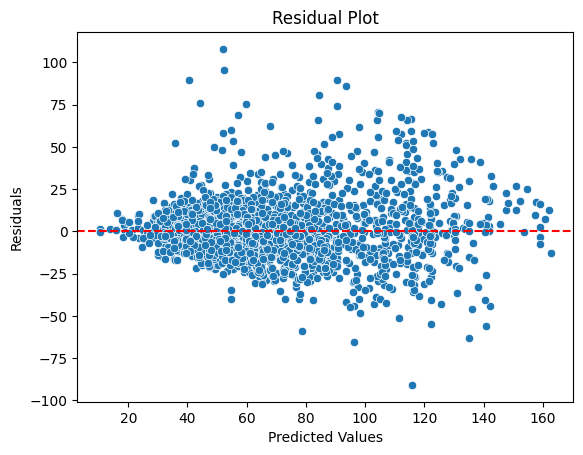

plot saved as 'residual_Analysis.png'


In [102]:
import seaborn as sns

y_pred = stack_model.predict(X_test)
residuals = y_test - y_pred

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Save to file
plt.savefig("../reports/residual_Analysis.png", dpi=500)
plt.close()

print("plot saved as 'residual_Analysis.png'")


**Error Distribution**

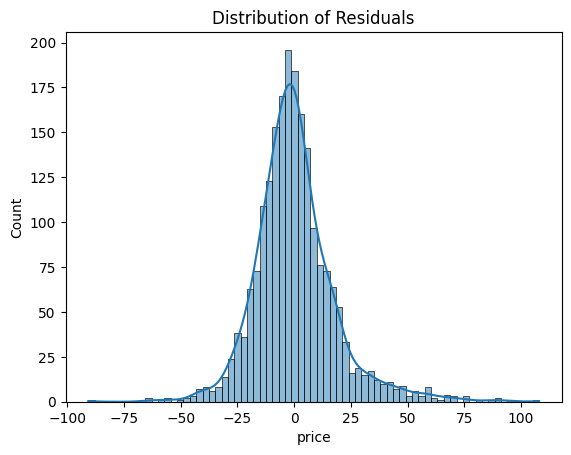

plot saved as 'error_distribution.png'


In [103]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

plt.savefig("../reports/error_distribution.png", dpi=500)
plt.close()

print("plot saved as 'error_distribution.png'")
